# Import Dependencies

In [1]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf

## Setup Mediapipe Algorithm

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results): 
    # Draw face connections 
    mp_drawing.draw_landmarks( 
      image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
      mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),  
      mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))  
    # Draw pose connections 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),  
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) 
                             )  
    # Draw left hand connections 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,  
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),  
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2) 
                             )  
    # Draw right hand connections   
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,  
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),  
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                             )  

## Video with MediaPipe

### With Frame Skip
To reduce the computational load. Frame skip methodology is introduced. Compare the above version with this version of speed.

In [6]:
video_path = 'bsl-dictionary-dataset/thanks/thanks_id1.mp4'
cap = cv2.VideoCapture(video_path)

# Set the new width and height for resizing
new_width = 680
new_height = 480

# Define the frame skip factor (process every Nth frame)
frame_skip = 9  # Adjust as needed

# Initialize a frame counter
frame_counter = 0

# Create a MediaPipe Holistic object
#Faster inference if model complexity to 0. 1 -> lower inference. 
# train in model complexity of 1 and then change to 0?
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5, model_complexity=0) as holistic:

    while cap.isOpened():
        ret, frame = cap.read()

        # if frame is read correctly, ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            continue

        # Increment the frame counter
        frame_counter += 1

        # Skip frames if the frame counter is not divisible by the frame_skip factor
        if frame_counter % frame_skip != 0:
            continue

        # Resize the frame
        resized_frame = cv2.resize(frame, (new_width, new_height))
        
        # Start the timer
        start_time = time.time()
        
        # Perform holistic pose detection on the resized frame
        image, results = mediapipe_detection(resized_frame, holistic)

        # Draw landmarks on the frame
        draw_styled_landmarks(image, results)

        # Display the processed frame
        cv2.imshow('frame', image)
        
        # Stop the timer, end of frame
        end_time = time.time()
        processing_time = end_time - start_time
        print(f"Frame {frame_counter}, PT: {1/processing_time:.4f}")

        # Break the loop if the 'q' key is pressed
        if cv2.waitKey(1) == ord('q'):
            break

    # Release the video capture object
    cap.release()

    # Close all OpenCV windows
    cv2.destroyAllWindows()

Frame 9, PT: 2.8909
Frame 18, PT: 12.8061
Frame 27, PT: 11.9707
Frame 36, PT: 12.5930
Can't receive frame (stream end?). Exiting ...
Frame 45, PT: 13.0674
Frame 54, PT: 13.0733
Frame 63, PT: 11.8304
Frame 72, PT: 12.4189
Frame 81, PT: 12.1899
Can't receive frame (stream end?). Exiting ...
Frame 90, PT: 12.4984
Frame 99, PT: 11.4930
Frame 108, PT: 12.8198
Frame 117, PT: 12.4551
Frame 126, PT: 11.9942
Can't receive frame (stream end?). Exiting ...
Frame 135, PT: 11.7226
Frame 144, PT: 12.7253
Frame 153, PT: 12.8302
Frame 162, PT: 11.6885
Frame 171, PT: 12.7310
Can't receive frame (stream end?). Exiting ...
Frame 180, PT: 12.8981
Frame 189, PT: 12.8838
Frame 198, PT: 13.4517
Frame 207, PT: 13.6859
Can't receive frame (stream end?). Exiting ...
Frame 216, PT: 12.2675
Frame 225, PT: 12.1183
Frame 234, PT: 12.4180
Frame 243, PT: 12.7295


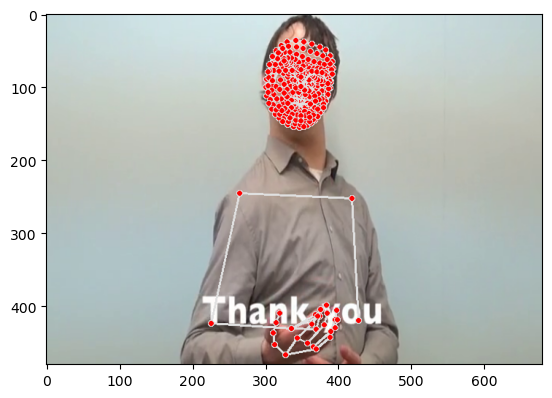

In [7]:
draw_landmarks(resized_frame, results)
# show the landmark taken
plt.imshow(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))

# Extracting Keypoint Values to Matrix

In [9]:
len(results.pose_landmarks.landmark) #outputs number of face landmarks. 


33

Based oon len. Clearly, there is 33 points for pose, 21 points for both hands, and 468 landmarks for face.

IF: camera didn't pick up then add in zeros to the numpy array. This ensures the array can still be fed into the machine learning even if it is not shown.

In [10]:
pose = []
##Put the landmark coordinates in the array via loop.
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test) ##put test content into pose array.

In [13]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [14]:
result_test = extract_keypoints(results)

In [15]:
result_test.shape

(1629,)

In [16]:
np.save('test_vid_matrix', result_test)

In [17]:
np.load('test_vid_matrix.npy')

array([ 0.51407564,  0.20842704, -0.9374029 , ...,  0.58729804,
        0.87476015, -0.04345106])

## Load Trained Model

In [19]:
#Load the trained model into.
#Note: ask for the kaggle parquet in order to make predictions easier. Load dataset from there
model_path = 'lstm-models/models-cloud/AK-LSTM128-DENSE128-DENSE256'
# Load the model
loaded_model = tf.keras.models.load_model(model_path)

In [ ]:
#optional with dataset: res = loaded_model.predict(X_test)

# Live Implementation

In [20]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [23]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: 'NormalizedLandmark' object is not iterable

<Figure size 1800x1800 with 0 Axes>

In [46]:
sequence.reverse()
len(sequence)

NameError: name 'sequence' is not defined

In [47]:
sequence.append('def')
sequence.reverse()

NameError: name 'sequence' is not defined

In [48]:
sequence[-30:]

NameError: name 'sequence' is not defined

In [25]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.6
new_width = 680
new_height = 480
actions = np.array(['listen', 'look', 'shhh'])

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        resized_frame = cv2.resize(frame, (new_width, new_height))

        # Make detections
        image, results = mediapipe_detection(resized_frame, holistic) 
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-60:]
        
        if len(sequence) == 60:
            res = loaded_model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti